In [179]:
%%capture
%pip install pandas numpy matplotlib seaborn scipy scikit-learn statsmodels mpl_toolkits

In [180]:
#### Import all the needed packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from mpl_toolkits.mplot3d import Axes3D  # Import the 3D plotting tool
from scipy.optimize import curve_fit
from scipy.stats import norm
from sklearn.metrics import mean_squared_error, r2_score

Reading and formatting the csv and dropping outliers 

In [181]:
csvFilePath = 'acc_data_200.csv'
df = pd.read_csv(csvFilePath)

### Standardized values
q = 0
r = 0.1 

### Filter junk values and best_beta
df = df[(df['best_beta'] >= 0.57)]

### Make sure columns are numeric
numeric_columns = ['T', 'm', 'sigma', 'H', 'S0', 'K', 'price_iter']
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

## Add the new paremeters
df['sigma_sqrt_T'] = df['sigma'] * np.sqrt(df['T']/df['m'])
df['H_log'] = abs(np.log(df['H'] / df['S0']))


Formula for calculating the proudct between sigma*sqrt(delta_T)

In [182]:
def calc_product(sigma, T,m):
    return sigma*np.sqrt(T/m)

Formulas from the Book

In [183]:
def get_parameter_values(S0, K, T, r, q, sigma): 
    # d1 and d2 
    d1 = (np.log(S0/K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
       
    # Lambda value 
    lambda_ = (r - q + 0.5 * sigma**2) / sigma**2
    
    # Vanilla call value
    c = S0 * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2) 
    
    return lambda_, c

def down_and_call_book(S0, K, T, r, q, sigma,H, H_down, H_up):
    
    # Values for the different functions 
    lambda_, c = get_parameter_values(S0, K, T, r, q, sigma)
    
    # Value for the down and out
    y = np.log(H_down**2 / (S0*K)) / (sigma * np.sqrt(T)) + lambda_ * sigma * np.sqrt(T)
    
    # Values for the down and in 
    x1 = np.log(S0/H_up) / (sigma * np.sqrt(T)) + lambda_ * sigma * np.sqrt(T)
    y1 = np.log(H_up/S0) / (sigma * np.sqrt(T)) + lambda_ * sigma * np.sqrt(T)

    # Calculate option values for call
    if H <= K:
        #Down and out
        cdi = S0 * np.exp(-q * T) * (H_down/S0)**(2*lambda_) * norm.cdf(y) - K * np.exp(-r * T) * (H_down/S0)**(2*lambda_ - 2) * norm.cdf(y - sigma * np.sqrt(T))
        cdo = c  - cdi
        return cdo
    else:
        #Down and in
        cdo = S0 * np.exp(-q * T) * norm.cdf(x1) - K * np.exp(-r * T) * norm.cdf(x1 - sigma * np.sqrt(T)) 
        - S0 * np.exp(-q * T) * (H_up/S0)**(2*lambda_) * norm.cdf(y1) + K * np.exp(-r * T) * (H_up/S0)**(2*lambda_ - 2) * norm.cdf(y1 - sigma * np.sqrt(T))
        cdi = c - cdo
        
        return cdi


Regression formulas for the new barrier

In [184]:
### Barrier engineer method
def regression_beta_estimate(T, sigma, H, S0, m):
    beta_start = 0.5826
    Sigma_sqrt_T = sigma*np.sqrt(T/m)
    H_log = np.log(H/S0)
    
    #### TODO find this as a function of 
    # beta_end = 7.1112e-01 / (1 + exp(-3.5196e+01(x - -5.5445e-02))) 
    beta_end =  0.71 / (1 + np.exp(-3.3*(Sigma_sqrt_T*10 + 0.55)))
       
    ### This is from the reg of increase point both Logistic and quadratic can be used
    H_log_start = -0.145 / (1 + np.exp(-3.3*(Sigma_sqrt_T*10 - beta_start)))
    #H_log_start =  - 9.5109e-02 / (1 + np.exp(-4.1247e+01*(Sigma_sqrt_T + 1.8610e+00)))  #(R² = 0.98)
    #H_log_start = 1.0170e+00*Sigma_sqrt_T + 1.0947e-02
    
    # Convert back to H value    
    H_end = np.log((S0 - 1)/S0)

    # Start with a constant beta
    beta = beta_start

    # If we've reached the start of the increase, switch to the polynomial curve
    if H_log >= H_log_start:
        # These are placeholders and should be solved based on your specific conditions
        a = (beta_end - beta_start) / ((H_end - H_log_start)**2)
        b = -2 * a * H_log_start
        c = beta_start + a * H_log_start**2
        
        # Polynomial growth formula
        beta = a * H_log**2 + b * H_log + c

    return beta


# Function to adjust the barrier for discrete monitoring
def adjusted_barrier_estimate(T, H, S0,sigma, m):
    # dT should be here, it "is the time between monitoring instants", p.325, also stated in book from michael at p.628
    delta_T = T / m
    beta = regression_beta_estimate(T, sigma, H, S0, m)

    ### adjust the beta value
    H_adj_down = H * np.exp(-1 * beta * sigma * np.sqrt(delta_T))
    H_adj_up = H * np.exp(beta * sigma * np.sqrt(delta_T))

    return H_adj_down, H_adj_up

Regression functions for the two models

Maximum Error - Original Method: 16.0385%, Max average: 12.6722 
Maximum Error - Custom Engineer: 2.5249%, Max average: 0.5455


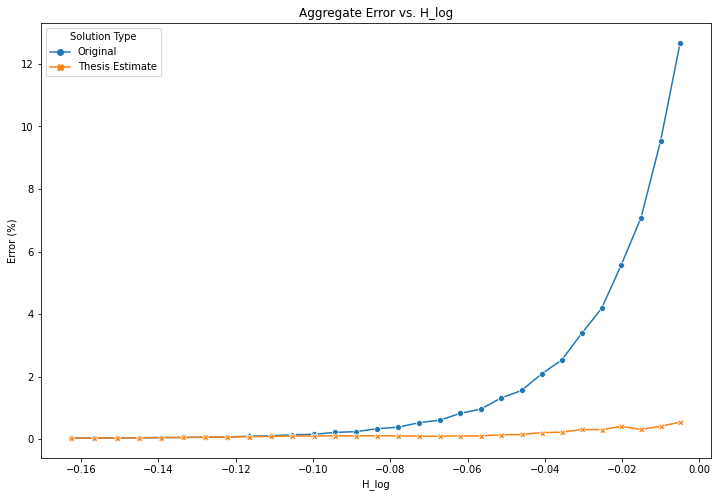

In [185]:
# Initialize a list to store error calculations
errors = []

for index, row in df.iterrows(): 
    # Extract necessary values from the row
    T, H, S0, K, sigma, m = row['T'], row['H'], row['S0'], row['K'], row['sigma'], row['m']
    H_log = (np.log(row['H']/row['S0']))

    # Engineering solution
    beta_engineer = regression_beta_estimate(T, sigma, H, S0, m)  # Get beta for engineering estimate
    H_down_engineer, H_up_engineer = adjusted_barrier_estimate(T, H, S0,sigma, m)
    price_engineer = down_and_call_book(S0, K, T, r, q, sigma, H, H_down_engineer, H_up_engineer)
    
    # Assuming price_original and price_iter are columns in df representing original and Monte Carlo prices
    price_mc = row['price_iter']
    error_original = round(abs(((price_mc - row['price_adj']) / price_mc) * 100), 5)
    error_estimate = round(abs(((price_mc - price_engineer) / price_mc) * 100), 5)
        
    errors.append({'H_log': H_log, 'Error': error_original, 'Type': 'Original'})
    errors.append({'H_log': H_log, 'Error': error_estimate, 'Type': 'Thesis Estimate'})

    best_beta = row['best_beta']

# Convert errors list to DataFrame for plotting
df_errors = pd.DataFrame(errors)

# Aggregate errors by H_log and Type
df_agg = df_errors.groupby(['H_log', 'Type'], as_index=False)['Error'].mean()

# Find the maximum error values for each method
max_error_original = df_errors[df_errors['Type'] == 'Original']['Error'].max()
max_error_estimate = df_errors[df_errors['Type'] == 'Thesis Estimate']['Error'].max()

print(f"Maximum Error - Original Method: {max_error_original:.4f}%, Max average: {df_agg[df_agg['Type'] == 'Original']['Error'].max():.4f} ")
print(f"Maximum Error - Custom Engineer: {max_error_estimate:.4f}%, Max average: {df_agg[df_agg['Type'] == 'Thesis Estimate']['Error'].max():.4f}")

# Plotting
plt.figure(figsize=(12, 8))
sns.lineplot(data=df_agg, x='H_log', y='Error', hue='Type', style='Type', markers=True, dashes=False)
plt.title('Aggregate Error vs. H_log')
plt.xlabel('H_log')
plt.ylabel('Error (%)')
plt.legend(title='Solution Type')
plt.show()